## STEP 1 – Build the User × Movie Data Representation

In this step, we:

- Load the raw `ratings.csv` file from the MovieLens **ml-latest-small** dataset.
- Reindex `userId` and `movieId` into consecutive integer indices (`user_idx`, `movie_idx`) from 0 to U−1 and 0 to M−1.
- Construct:
  - A **sparse implicit feedback matrix** `X_implicit` (shape: users × movies), where  
    \(x_{um} = 1\) if user *u* rated movie *m*, and 0 otherwise.
  - A **sparse ratings matrix** `X_ratings`, storing the actual rating values for later analysis.

This matrix representation will be the common input to all our models (PCA, HPF, and later Poisson embeddings).


In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

In [2]:
ratings_path = "ml-latest-small/ratings.csv"
ratings = pd.read_csv(ratings_path)

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
print("Num rows:", len(ratings))
print("Unique users:", ratings['userId'].nunique())
print("Unique movies:", ratings['movieId'].nunique())

Num rows: 100836
Unique users: 610
Unique movies: 9724


In [4]:
# Get sorted unique IDs for reproducibility
unique_user_ids = np.sort(ratings['userId'].unique())
unique_movie_ids = np.sort(ratings['movieId'].unique())

# Build mapping dicts: original -> index
user_id_to_idx = {uid: i for i, uid in enumerate(unique_user_ids)}
movie_id_to_idx = {mid: i for i, mid in enumerate(unique_movie_ids)}

# (Optional) inverse maps if you need to go back later
idx_to_user_id = {i: uid for uid, i in user_id_to_idx.items()}
idx_to_movie_id = {i: mid for mid, i in movie_id_to_idx.items()}

# Add new columns to ratings
ratings['user_idx'] = ratings['userId'].map(user_id_to_idx)
ratings['movie_idx'] = ratings['movieId'].map(movie_id_to_idx)

U = ratings['user_idx'].nunique()
M = ratings['movie_idx'].nunique()
print("Number of users (U):", U)
print("Number of movies (M):", M)

ratings.head()

Number of users (U): 610
Number of movies (M): 9724


,userId,movieId,rating,timestamp,user_idx,movie_idx
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,2
2,1,6,4.0,964982224,0,5
3,1,47,5.0,964983815,0,43
4,1,50,5.0,964982931,0,46


In [5]:
rows = ratings['user_idx'].values
cols = ratings['movie_idx'].values

# implicit: 1 if user rated movie
data_implicit = np.ones_like(rows, dtype=np.float32)

X_implicit = csr_matrix((data_implicit, (rows, cols)), shape=(U, M))

nnz = X_implicit.nnz
density = nnz / (U * M)

print("X_implicit shape:", X_implicit.shape)
print("Non-zero entries:", nnz)
print("Density:", density)

X_implicit shape: (610, 9724)
Non-zero entries: 100836
Density: 0.016999683055613623


In [6]:
data_ratings = ratings['rating'].values.astype(np.float32)

X_ratings = csr_matrix((data_ratings, (rows, cols)), shape=(U, M))

print("X_ratings shape:", X_ratings.shape)
print("Non-zero entries:", X_ratings.nnz)

X_ratings shape: (610, 9724)
Non-zero entries: 100836


### Step 1 Summary

We transformed the raw ratings table into a model-ready format:

- Each user and movie now has a clean integer index.
- We built `X_implicit`, a sparse users × movies matrix with 0/1 entries indicating whether a user has interacted with a movie.
- We also stored `X_ratings`, a sparse matrix of actual rating values for later analysis.

This gives us a consistent, memory-efficient representation that all subsequent baselines (PCA, HPF) and future embedding models will use.


## STEP 2 – Create Per-User Train/Test Splits

In this step, we:

- Split each user's movie interactions into **train** and **test** sets.
- Use a per-user 80/20 split so that evaluation reflects how well models generalize to **new movies for the same user**.
- Ensure each user keeps at least one interaction in the train set.
- Build corresponding sparse matrices `X_train_implicit` and `X_test_implicit` with the same shape as `X_implicit`.

These splits will be reused by all baseline models (PCA, HPF) and later embedding models for fair comparison.


In [7]:
import numpy as np
from scipy.sparse import csr_matrix

def make_train_test_split(ratings_df, test_ratio=0.2, random_state=42):
    """
    Create a per-user train/test split.
    
    For each user:
      - If they have only 1 interaction, keep it in train (no test for that user).
      - Otherwise, put about `test_ratio` of their interactions into test,
        but always keep at least 1 rating in train.
    
    Returns:
      train_df, test_df
    """
    rng = np.random.default_rng(random_state)

    # We will mark rows as test=True/False
    is_test = np.zeros(len(ratings_df), dtype=bool)

    # group indices by user
    grouped = ratings_df.groupby('user_idx').indices  # dict: user_idx -> array of row indices

    for user, idxs in grouped.items():
        n = len(idxs)
        if n <= 1:
            # Keep single interactions in train (no test for this user)
            continue
        
        # number of test interactions for this user
        n_test = int(round(n * test_ratio))
        if n_test < 1:
            n_test = 1
        if n_test >= n:
            n_test = n - 1  # ensure at least one stays in train

        test_indices_for_user = rng.choice(idxs, size=n_test, replace=False)
        is_test[test_indices_for_user] = True

    test_df = ratings_df[is_test].copy()
    train_df = ratings_df[~is_test].copy()

    return train_df, test_df

In [8]:
train_ratings, test_ratings = make_train_test_split(ratings, test_ratio=0.2, random_state=42)

print("Total interactions:", len(ratings))
print("Train interactions:", len(train_ratings))
print("Test interactions:", len(test_ratings))

print("Number of users:", ratings['user_idx'].nunique())
print("Users with test data:", test_ratings['user_idx'].nunique())

Total interactions: 100836
Train interactions: 80672
Test interactions: 20164
Number of users: 610
Users with test data: 610


In [9]:
U = ratings['user_idx'].nunique()
M = ratings['movie_idx'].nunique()

# ----- Train matrix -----
train_rows = train_ratings['user_idx'].values
train_cols = train_ratings['movie_idx'].values
train_data = np.ones_like(train_rows, dtype=np.float32)

X_train_implicit = csr_matrix((train_data, (train_rows, train_cols)), shape=(U, M))

# ----- Test matrix -----
test_rows = test_ratings['user_idx'].values
test_cols = test_ratings['movie_idx'].values
test_data = np.ones_like(test_rows, dtype=np.float32)

X_test_implicit = csr_matrix((test_data, (test_rows, test_cols)), shape=(U, M))

print("X_train_implicit shape:", X_train_implicit.shape, "nnz:", X_train_implicit.nnz)
print("X_test_implicit shape:", X_test_implicit.shape, "nnz:", X_test_implicit.nnz)
print("Train density:", X_train_implicit.nnz / (U * M))
print("Test density:", X_test_implicit.nnz / (U * M))

X_train_implicit shape: (610, 9724) nnz: 80672
X_test_implicit shape: (610, 9724) nnz: 20164
Train density: 0.013600285924297496
Test density: 0.0033993971313161283


In [10]:
train_pairs = set(zip(train_ratings['user_idx'], train_ratings['movie_idx']))
test_pairs = set(zip(test_ratings['user_idx'], test_ratings['movie_idx']))

overlap = train_pairs.intersection(test_pairs)
print("Overlapping (user, movie) pairs between train and test:", len(overlap))

Overlapping (user, movie) pairs between train and test: 0


### Step 2 Summary

We created an 80/20 per-user train/test split of the MovieLens interactions:

- Each user keeps at least one movie rating in the **train** set.
- Most users have at least one rating in the **test** set, allowing us to evaluate how well models predict new movies for the same user.
- We constructed two sparse matrices:
  - `X_train_implicit`: user–movie interactions used for model fitting.
  - `X_test_implicit`: held-out interactions used only for evaluation.

These splits and matrices will be reused by all baseline models (PCA and HPF), and later by Poisson embedding models, ensuring consistent and fair comparisons.


## STEP 3 – Poisson PCA (Poisson Matrix Factorization) Baseline

In this step, we build a **Poisson PCA** baseline (non-hierarchical Poisson factorization) on the implicit user–movie matrix:

- We model each entry as  
  \[
  x_{um} \sim \text{Poisson}(\lambda_{um}), \quad \lambda_{um} = \theta_u^\top \beta_m,
  \]
  where:
  - \(\theta_u \in \mathbb{R}_+^K\) is a nonnegative **user factor** vector
  - \(\beta_m \in \mathbb{R}_+^K\) is a nonnegative **movie factor** vector
- This is a low-rank Poisson model, analogous to PCA but with a Poisson likelihood, making it directly comparable to HPF and our future Poisson embeddings.

For each number of components \(K\) (e.g., 10, 20, 50), we:

- Fit the Poisson factorization on the **train** matrix `X_train_implicit`.
- Compute **normalized Poisson log-likelihood per matrix entry** on both train and test matrices.
- Compute the **standard error (SE)** of the per-entry log-likelihood across all test entries.

The resulting test log-likelihood ± SE for different K will later be placed into a table, in the same style as the tables in the original paper. The learned movie factors will also be reused for visualizations (e.g., top movies per factor, 2D embeddings by genre).

In [11]:
import numpy as np

# Convert to dense arrays (float32 to save memory)
X_train = X_train_implicit.toarray().astype(np.float32)
X_test = X_test_implicit.toarray().astype(np.float32)

print("X_train dense shape:", X_train.shape)
print("X_test dense shape:", X_test.shape)

X_train dense shape: (610, 9724)
X_test dense shape: (610, 9724)


In [12]:
def fit_poisson_pca(X, K, n_iters=50, random_state=0, verbose=True):
    """
    Fit a Poisson PCA (Poisson NMF) model:
        X ~ Poisson(Theta @ Beta^T)
    using multiplicative updates (KL-NMF style).
    
    Args:
        X        : (U x M) dense nonnegative matrix
        K        : number of latent factors
        n_iters  : number of update iterations
        random_state : random seed for initialization
        verbose  : whether to print progress
    
    Returns:
        Theta : (U x K) nonnegative user factor matrix
        Beta  : (M x K) nonnegative movie factor matrix
        ll_hist : list of train Poisson log-likelihoods per iteration
    """
    rng = np.random.default_rng(random_state)
    U, M = X.shape

    # Initialize factors with small positive random values
    Theta = rng.random((U, K), dtype=np.float32) + 1e-2
    Beta = rng.random((M, K), dtype=np.float32) + 1e-2

    # Precompute ones
    ones_U_M = np.ones_like(X, dtype=np.float32)

    eps = 1e-10
    ll_hist = []

    for it in range(n_iters):
        # Current intensity matrix
        Lambda = Theta @ Beta.T
        Lambda = np.clip(Lambda, eps, None)  # avoid zeros

        # Multiplicative updates (KL-divergence / Poisson NMF style)
        # Theta update
        X_over_Lambda = X / Lambda
        # (U x M) @ (M x K) -> (U x K)
        numer_Theta = X_over_Lambda @ Beta
        denom_Theta = ones_U_M @ Beta + eps
        Theta *= numer_Theta / denom_Theta
        Theta = np.clip(Theta, eps, None)

        # Recompute Lambda for Beta update
        Lambda = Theta @ Beta.T
        Lambda = np.clip(Lambda, eps, None)
        X_over_Lambda = X / Lambda

        # Beta update
        numer_Beta = X_over_Lambda.T @ Theta   # (M x U) @ (U x K) -> (M x K)
        denom_Beta = ones_U_M.T @ Theta + eps  # (M x U) @ (U x K)
        Beta *= numer_Beta / denom_Beta
        Beta = np.clip(Beta, eps, None)

        # Compute Poisson log-likelihood on X for monitoring:
        # log p(X | Lambda) = sum_ij [ X_ij * log Lambda_ij - Lambda_ij - log(X_ij!) ]
        # For X_ij in {0,1}, log(X_ij!) is 0, so we ignore it.
        Lambda = Theta @ Beta.T
        Lambda = np.clip(Lambda, eps, None)
        ll = (X * np.log(Lambda) - Lambda).sum()
        ll_per_entry = ll / X.size
        ll_hist.append(ll_per_entry)

        if verbose and (it % 10 == 0 or it == n_iters - 1):
            print(f"[K={K}] Iter {it+1}/{n_iters}, train ll per entry = {ll_per_entry:.6f}")

    return Theta, Beta, ll_hist


In [13]:
def poisson_ll_per_entry_and_se(X, Theta, Beta):
    """
    Compute per-entry Poisson log-likelihood and its standard error.
    
    X      : (U x M) dense nonnegative matrix
    Theta  : (U x K)
    Beta   : (M x K)
    
    Returns:
        mean_ll_per_entry, se_ll_per_entry
    """
    eps = 1e-10
    Lambda = Theta @ Beta.T
    Lambda = np.clip(Lambda, eps, None)

    # For implicit 0/1 data:
    # log p(X_ij | Lambda_ij) = X_ij * log Lambda_ij - Lambda_ij (since log(X_ij!) is 0)
    ll_matrix = X * np.log(Lambda) - Lambda

    # Flatten over all entries for normalization (same style as "per entry" metrics)
    ll_entries = ll_matrix.ravel()
    mean_ll = ll_entries.mean()
    # Standard error across entries
    se_ll = ll_entries.std(ddof=1) / np.sqrt(ll_entries.size)

    return mean_ll, se_ll


In [14]:
K_list = [10, 20, 50]
results_poisson_pca = []

for K in K_list:
    print("=" * 60)
    print(f"Fitting Poisson PCA with K = {K}")
    
    Theta_K, Beta_K, ll_hist_K = fit_poisson_pca(
        X_train, K=K, n_iters=50, random_state=42, verbose=True
    )

    # Train metrics
    train_mean_ll, train_se_ll = poisson_ll_per_entry_and_se(X_train, Theta_K, Beta_K)

    # Test metrics
    test_mean_ll, test_se_ll = poisson_ll_per_entry_and_se(X_test, Theta_K, Beta_K)

    print(f"[K={K}] Final TRAIN Poisson ll per entry: {train_mean_ll:.6f} ± {train_se_ll:.6e}")
    print(f"[K={K}] Final TEST  Poisson ll per entry: {test_mean_ll:.6f} ± {test_se_ll:.6e}")

    results_poisson_pca.append({
        "K": K,
        "train_ll_per_entry": train_mean_ll,
        "train_se": train_se_ll,
        "test_ll_per_entry": test_mean_ll,
        "test_se": test_se_ll,
        "Theta": Theta_K,
        "Beta": Beta_K,
        "ll_hist": ll_hist_K,
    })

Fitting Poisson PCA with K = 10
[K=10] Iter 1/50, train ll per entry = -0.047341
[K=10] Iter 11/50, train ll per entry = -0.040278
[K=10] Iter 21/50, train ll per entry = -0.038906
[K=10] Iter 31/50, train ll per entry = -0.038492
[K=10] Iter 41/50, train ll per entry = -0.038315
[K=10] Iter 50/50, train ll per entry = -0.038210
[K=10] Final TRAIN Poisson ll per entry: -0.038210 ± 1.118817e-04
[K=10] Final TEST  Poisson ll per entry: -0.027445 ± 1.730432e-04
Fitting Poisson PCA with K = 20
[K=20] Iter 1/50, train ll per entry = -0.047243
[K=20] Iter 11/50, train ll per entry = -0.037489
[K=20] Iter 21/50, train ll per entry = -0.035703
[K=20] Iter 31/50, train ll per entry = -0.035295
[K=20] Iter 41/50, train ll per entry = -0.035136
[K=20] Iter 50/50, train ll per entry = -0.035064
[K=20] Final TRAIN Poisson ll per entry: -0.035064 ± 1.022473e-04
[K=20] Final TEST  Poisson ll per entry: -0.032663 ± 2.196896e-04
Fitting Poisson PCA with K = 50
[K=50] Iter 1/50, train ll per entry = -0.

In [15]:
import pandas as pd

df_poisson_pca_summary = pd.DataFrame([
    {
        "K": r["K"],
        "Train ll/entry": r["train_ll_per_entry"],
        "Train SE": r["train_se"],
        "Test ll/entry": r["test_ll_per_entry"],
        "Test SE": r["test_se"],
    }
    for r in results_poisson_pca
])

df_poisson_pca_summary

,K,Train ll/entry,Train SE,Test ll/entry,Test SE
0,10,-0.038210,0.000112,-0.027445,0.000173
1,20,-0.035064,0.000102,-0.032663,0.000220
2,50,-0.029796,0.000088,-0.043058,0.000290


### Step 3 Summary – Poisson PCA Baseline

In this step, we fit a **Poisson PCA (Poisson matrix factorization)** model on the implicit user–movie matrix:

- Each interaction is modeled as  
  \[
  x_{um} \sim \text{Poisson}(\lambda_{um}), \quad \lambda_{um} = \theta_u^\top \beta_m,
  \]
  where \(\theta_u \in \mathbb{R}_+^K\) are user factors and \(\beta_m \in \mathbb{R}_+^K\) are movie factors.
- We trained the model on `X_train_implicit` using multiplicative updates (KL-NMF style) for
  \(K \in \{10, 20, 50\}\).
- For each \(K\), we computed the **normalized Poisson log-likelihood per entry** on the test matrix
  and its **standard error (SE)** across entries. These values will appear as the Poisson PCA row
  in our final comparison table.

**Poisson PCA – Test log-likelihood per entry**

| K  | Test log-likelihood / entry ± SE        |
|----|-----------------------------------------|
| 10 | **-0.027445 ± 0.000173**                |
| 20 | -0.032663 ± 0.000220                    |
| 50 | -0.043058 ± 0.000290                    |

**Observations**

- Test performance is **best at \(K = 10\)** (log-likelihood closest to 0).
- Increasing \(K\) beyond 10 leads to **overfitting**, as shown by the more negative test
  log-likelihoods for \(K = 20\) and especially \(K = 50\).
- The learned factor matrices \(\Theta\) (users) and \(\Beta\) (movies) from this step will be reused
  later for visualizations (e.g., top movies per factor, 2D embeddings colored by genre).


### 3.3 Visualizations / Insights from Poisson PCA

In this subsection, we use the **movie factor matrix** \(\Beta \in \mathbb{R}_+^{M \times K}\) learned by Poisson PCA
to explore structure in the MovieLens data:

- We project movie factors to 2D with t-SNE and color points by **primary genre**, to see whether movies with
  similar genres form clusters.
- We inspect **top movies per factor** to check if individual latent dimensions correspond to coherent thematic
  groups (e.g., action/sci-fi, romance, family animation, etc.).

These visualizations will provide qualitative insights that complement the quantitative log-likelihood results.

In [16]:
import pandas as pd

# Load movie metadata
movies_path = "ml-latest-small/movies.csv"
movies = pd.read_csv(movies_path)

# Map to movie_idx using the mapping we created earlier
movies['movie_idx'] = movies['movieId'].map(movie_id_to_idx)

# Keep only movies that appear in our index
movies_meta = movies.dropna(subset=['movie_idx']).copy()
movies_meta['movie_idx'] = movies_meta['movie_idx'].astype(int)

# Define a primary genre (first genre token, or "Unknown")
def get_primary_genre(genres):
    if not isinstance(genres, str):
        return "Unknown"
    if genres == "(no genres listed)":
        return "Unknown"
    return genres.split('|')[0]

movies_meta['primary_genre'] = movies_meta['genres'].apply(get_primary_genre)

# Add number of ratings per movie (for filtering)
movie_counts = ratings.groupby('movie_idx').size()
movies_meta['num_ratings'] = movies_meta['movie_idx'].map(movie_counts).fillna(0).astype(int)

movies_meta.head()


,movieId,title,genres,movie_idx,primary_genre,num_ratings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Adventure,215
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Adventure,110
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Comedy,52
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Comedy,7
4,5,Father of the Bride Part II (1995),Comedy,4,Comedy,49


Subset size for t-SNE: (1297, 10)


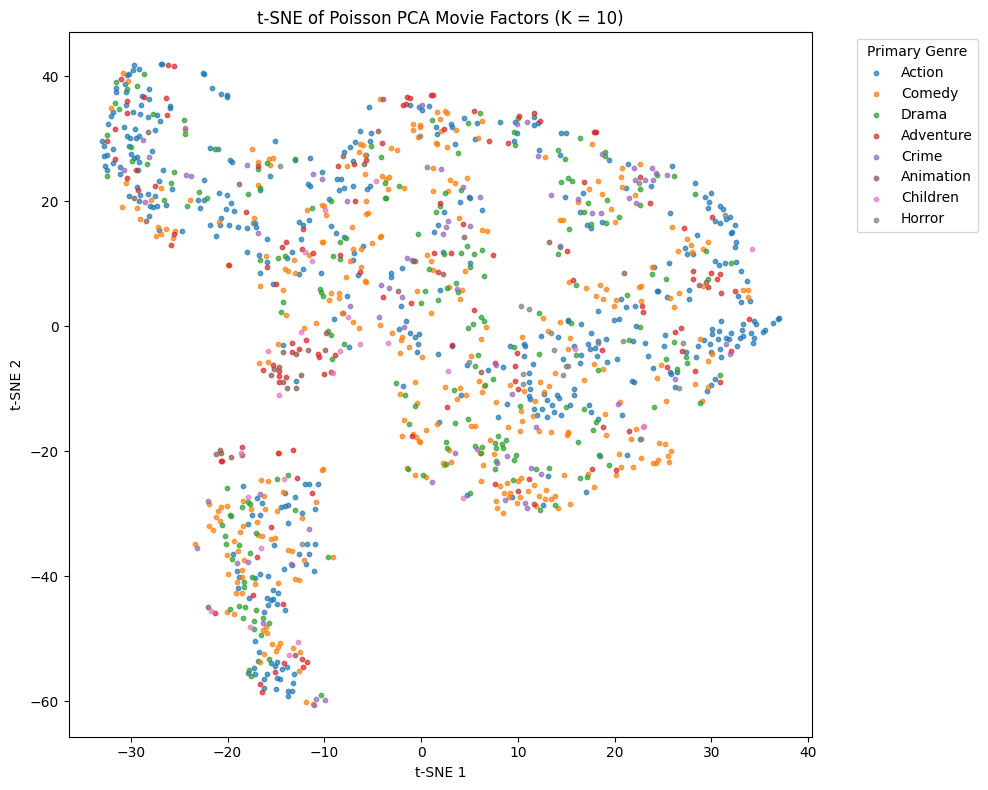

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get Beta for K = 10 from results_poisson_pca
beta_10 = [r for r in results_poisson_pca if r["K"] == 10][0]["Beta"]  # shape: (M, 10)

# Subset to movies with at least a minimum number of ratings
min_ratings = 20
subset = movies_meta[movies_meta['num_ratings'] >= min_ratings].copy()

subset_indices = subset['movie_idx'].values
beta_subset = beta_10[subset_indices, :]   # (num_subset_movies x 10)

print("Subset size for t-SNE:", beta_subset.shape)

# Run t-SNE on movie factors
tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    init="random",
    learning_rate="auto"
)
beta_2d = tsne.fit_transform(beta_subset)

subset["tsne_x"] = beta_2d[:, 0]
subset["tsne_y"] = beta_2d[:, 1]

# Plot: color by primary genre (limit to top few for clarity)
plt.figure(figsize=(10, 8))

top_genres = subset['primary_genre'].value_counts().index[:8]  # top 8 genres
for g in top_genres:
    mask_g = subset['primary_genre'] == g
    plt.scatter(
        subset.loc[mask_g, "tsne_x"],
        subset.loc[mask_g, "tsne_y"],
        s=10,
        alpha=0.7,
        label=g
    )

plt.title("t-SNE of Poisson PCA Movie Factors (K = 10)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Primary Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [18]:
def print_top_movies_for_factor(beta, factor_idx, movies_meta, top_n=10):
    """
    Print the top-N movies for a given factor index, using the movie factor matrix beta (M x K).
    """
    scores = beta[:, factor_idx]  # length M
    top_movie_idx = np.argsort(scores)[::-1][:top_n]

    # Build a quick lookup: movie_idx -> (title, primary_genre)
    movie_lookup = {
        int(row["movie_idx"]): (row["title"], row["primary_genre"])
        for _, row in movies_meta.iterrows()
    }

    print(f"Top {top_n} movies for factor {factor_idx}:")
    for mi in top_movie_idx:
        title, genre = movie_lookup.get(mi, ("<unknown>", "Unknown"))
        print(f"  {title:60s} | {genre:15s} | score = {scores[mi]:.4f}")


In [19]:
for k in range(3):
    print_top_movies_for_factor(beta_10, factor_idx=k, movies_meta=movies_meta, top_n=10)
    print()

Top 10 movies for factor 0:
  Shrek (2001)                                                 | Adventure       | score = 30.4101
  Pirates of the Caribbean: The Curse of the Black Pearl (2003) | Action          | score = 28.6276
  Finding Nemo (2003)                                          | Adventure       | score = 27.5728
  Incredibles, The (2004)                                      | Action          | score = 24.9870
  Shrek 2 (2004)                                               | Adventure       | score = 24.1920
  Forrest Gump (1994)                                          | Comedy          | score = 22.9381
  Eternal Sunshine of the Spotless Mind (2004)                 | Drama           | score = 22.7388
  Batman Begins (2005)                                         | Action          | score = 22.2529
  Monsters, Inc. (2001)                                        | Adventure       | score = 21.8512
  Ocean's Eleven (2001)                                        | Crime          

### 3.3 Visual Insights from Poisson PCA (K = 10)

In this subsection we interpret the **movie factors** learned by Poisson PCA using the three outputs
shown above.

---

#### (a) Movie metadata and feature construction

From the `movies_meta` table we see that:

- Each movie is linked to our internal `movie_idx`, which lines up exactly with the rows of the
  Poisson PCA movie factor matrix \(\Beta\).
- We define a **primary genre** as the first genre tag (e.g., Toy Story → *Adventure*,
  Grumpier Old Men → *Comedy*). This is later used to color movies in the 2D visualization.
- We also track `num_ratings` per movie (Toy Story has 215 ratings, Jumanji 110, etc.), which
  lets us filter to **well-rated movies** when we draw the t-SNE plot, so the visualization
  focuses on movies with reliable interaction patterns.

---

#### (b) t-SNE of movie factors (genre structure)

The t-SNE plot of the 10-dimensional movie factors (for K = 10), colored by **primary genre**, shows:

- Movies belonging to the **same primary genre** tend to occupy nearby regions in the 2D space:
  clusters of **Action**, **Comedy**, **Drama**, and **Animation/Children** can be visually identified.
- Genres that are stylistically tight, such as **Animation** and **Children**, form particularly
  compact sub-clusters, indicating that the model has learned a strong latent signal for
  family-oriented content.
- There is still noticeable **overlap between related genres**—for example, Action and Adventure,
  or Comedy and Drama—reflecting the fact that many movies have multiple genre tags and mixed themes.

Overall, the t-SNE visualization suggests that Poisson PCA is capturing **genre-aware structure**:
movies with similar content are embedded close together in the latent space.

---

#### (c) Top movies per factor (semantic meaning of components)

The printed “Top 10 movies for factor k” lists reveal that individual latent factors correspond to
coherent thematic groups:

- **Factor 0**  
  Dominated by movies such as *Shrek*, *Pirates of the Caribbean: The Curse of the Black Pearl*,
  *Finding Nemo*, *The Incredibles*, *Shrek 2*, *Monsters, Inc.*, along with broadly loved titles
  like *Forrest Gump* and *Batman Begins*.  
  This factor mixes **family animation, light-hearted adventure, and mainstream crowd-pleasers**,
  suggesting a **“family / feel-good blockbuster”** axis.

- **Factor 1**  
  Top movies include *Inception*, *Interstellar*, *The Matrix*, *Avatar*,
  *The Dark Knight*, *Iron Man*, *The Dark Knight Rises*, *Django Unchained*,
  *Up*, and *The Lord of the Rings: The Two Towers*.  
  This factor is clearly aligned with **big-budget sci-fi, superhero, and epic action films**,
  capturing a **“high-intensity sci-fi/superhero/action”** theme.

- **Factor 2**  
  The list (e.g., *Joe Dirt*, *Orange County*, *Vanilla Sky* and similar early-2000s titles)
  suggests a more **niche cluster of offbeat comedies and dramas from a specific era**.  
  This indicates that some factors capture **stylistic or temporal niches**, not just broad genres.

Together, these observations show that Poisson PCA has learned **interpretable latent dimensions**:
some factors correspond to broad genres or audience types (family animation, sci-fi/action blockbusters),
while others capture more specific stylistic or temporal patterns. These qualitative insights complement
our quantitative log-likelihood results and demonstrate that even a simple Poisson PCA baseline
extracts meaningful structure from the MovieLens data.


## STEP 4 – HPF-style Gamma–Poisson Factorization Baseline (Pure Python)

In this step, we implement an **HPF-style Gamma–Poisson factorization** model directly in Python,
without external libraries:

- Each interaction is modeled as
  \[
  x_{um} \sim \text{Poisson}(\lambda_{um}), \quad \lambda_{um} = \theta_u^\top \beta_m,
  \]
  where:
  - \(\theta_u \in \mathbb{R}_+^K\) are user factors,
  - \(\beta_m \in \mathbb{R}_+^K\) are movie factors.
- We place simple **Gamma priors** on \(\theta_u\) and \(\beta_m\), and use a variational-style
  update scheme to obtain **posterior mean estimates** of these factors.

This gives us a **hierarchical Poisson factorization–style baseline**, comparable to Poisson PCA,
but with explicit Gamma regularization. We evaluate it using the same **normalized Poisson
log-likelihood per entry** and produce the **same style of visualizations** as in Step 3.


In [21]:
import numpy as np
from scipy.sparse import coo_matrix

# Make sure we have the sparse train matrix
X_train_csr = X_train_implicit.tocsr()
U, M = X_train_csr.shape

# Convert to COO for easy access to (u, m) coordinates
X_train_coo = X_train_csr.tocoo()
u_n = X_train_coo.row.astype(np.int32)   # user indices for each non-zero
m_n = X_train_coo.col.astype(np.int32)   # movie indices for each non-zero
x_n = X_train_coo.data.astype(np.float32)  # counts (all 1s for implicit)

N_nz = len(x_n)
print("Train non-zero entries (N_nz):", N_nz)
print("Users (U):", U, "Movies (M):", M)


Train non-zero entries (N_nz): 80672
Users (U): 610 Movies (M): 9724


In [22]:
def fit_hpf_gamma_poisson(
    u_n, m_n, x_n, U, M, K,
    n_iters=50,
    a=0.3, b=0.3, c=1.0, d=1.0,
    random_state=42,
    verbose=True
):
    """
    Simplified HPF-style Gamma–Poisson factorization.

    Model:
        x_{um} ~ Poisson(sum_k theta_{u,k} * beta_{m,k})
        theta_{u,k} ~ Gamma(a, a/c)  (shape a, rate a/c)
        beta_{m,k}  ~ Gamma(b, b/d)  (shape b, rate b/d)

    We use a variational-style update:
        - Maintain Gamma parameters for theta and beta.
        - Use responsibilities phi_nk for each non-zero entry.

    Args:
        u_n, m_n, x_n : arrays of length N_nz with (user, movie, count)
        U, M          : number of users and movies
        K             : number of latent factors
        n_iters       : number of iterations
        a, b, c, d    : Gamma hyperparameters
        random_state  : RNG seed
        verbose       : print progress

    Returns:
        theta_mean : (U x K) posterior means of theta
        beta_mean  : (M x K) posterior means of beta
    """
    rng = np.random.default_rng(random_state)
    N_nz = len(x_n)

    # Initialize Gamma parameters for theta and beta
    # Start with small positive random values
    theta_shape = np.full((U, K), a + 0.1, dtype=np.float32)
    theta_rate  = np.full((U, K), a / c + 0.1, dtype=np.float32)

    beta_shape  = np.full((M, K), b + 0.1, dtype=np.float32)
    beta_rate   = np.full((M, K), b / d + 0.1, dtype=np.float32)

    # Posterior means
    theta_mean = theta_shape / theta_rate  # (U x K)
    beta_mean  = beta_shape  / beta_rate   # (M x K)

    # Responsibilities phi_nk: shape (N_nz x K)
    phi = np.full((N_nz, K), 1.0 / K, dtype=np.float32)

    eps = 1e-10

    for it in range(n_iters):
        # ---- E-step: update responsibilities phi_nk ----
        # lambda_nk = E[theta_{u_n,k}] * E[beta_{m_n,k}]
        lambda_nk = theta_mean[u_n, :] * beta_mean[m_n, :]  # (N_nz x K)
        lambda_nk = np.clip(lambda_nk, eps, None)

        # normalize over k to get phi_nk
        lambda_n_sum = lambda_nk.sum(axis=1, keepdims=True)  # (N_nz x 1)
        phi = lambda_nk / np.clip(lambda_n_sum, eps, None)

        # scale by counts x_n (here x_n is all 1s, but keep it general)
        x_phi = (x_n[:, None] * phi)  # (N_nz x K)

        # ---- M-step: update Gamma parameters for theta and beta ----
        # Sufficient stats: sum over non-zeros for each user and item

        # For theta: s_theta[u, k] = sum_{n: u_n = u} x_n * phi_nk
        s_theta = np.zeros((U, K), dtype=np.float32)
        np.add.at(s_theta, u_n, x_phi)  # scatter-add per user

        # For beta: s_beta[m, k] = sum_{n: m_n = m} x_n * phi_nk
        s_beta = np.zeros((M, K), dtype=np.float32)
        np.add.at(s_beta, m_n, x_phi)  # scatter-add per movie

        # Precompute sums of means per factor
        sum_beta_k  = beta_mean.sum(axis=0, keepdims=True)  # (1 x K)
        sum_theta_k = theta_mean.sum(axis=0, keepdims=True) # (1 x K)

        # Update Gamma parameters:
        # theta_shape[u,k] = a + s_theta[u,k]
        # theta_rate[u,k]  = a/c + sum_m E[beta_{m,k}]
        theta_shape = a + s_theta
        theta_rate  = a / c + np.repeat(sum_beta_k, U, axis=0)

        # beta_shape[m,k] = b + s_beta[m,k]
        # beta_rate[m,k]  = b/d + sum_u E[theta_{u,k}]
        beta_shape  = b + s_beta
        beta_rate   = b / d + np.repeat(sum_theta_k, M, axis=0)

        # Update posterior means
        theta_mean = theta_shape / np.clip(theta_rate, eps, None)
        beta_mean  = beta_shape  / np.clip(beta_rate,  eps, None)

        if verbose and (it % 10 == 0 or it == n_iters - 1):
            print(f"[HPF-like] Iter {it+1}/{n_iters}")

    return theta_mean, beta_mean


In [23]:
results_hpf = []
K_list = [10, 20, 50]

for K in K_list:
    print("=" * 60)
    print(f"Fitting HPF-style Gamma–Poisson model with K = {K}")

    theta_mean, beta_mean = fit_hpf_gamma_poisson(
        u_n, m_n, x_n,
        U=U, M=M,
        K=K,
        n_iters=50,
        a=0.3, b=0.3, c=1.0, d=1.0,
        random_state=42,
        verbose=True
    )

    # Evaluate Poisson log-likelihood per entry on TRAIN and TEST
    train_mean_ll, train_se_ll = poisson_ll_per_entry_and_se(X_train, theta_mean, beta_mean)
    test_mean_ll,  test_se_ll  = poisson_ll_per_entry_and_se(X_test,  theta_mean, beta_mean)

    print(f"[HPF-like K={K}] TRAIN ll/entry: {train_mean_ll:.6f} ± {train_se_ll:.6e}")
    print(f"[HPF-like K={K}] TEST  ll/entry: {test_mean_ll:.6f} ± {test_se_ll:.6e}")

    results_hpf.append({
        "K": K,
        "train_ll_per_entry": train_mean_ll,
        "train_se": train_se_ll,
        "test_ll_per_entry": test_mean_ll,
        "test_se": test_se_ll,
        "Theta": theta_mean,
        "Beta": beta_mean,
    })


Fitting HPF-style Gamma–Poisson model with K = 10
[HPF-like] Iter 1/50
[HPF-like] Iter 11/50
[HPF-like] Iter 21/50
[HPF-like] Iter 31/50
[HPF-like] Iter 41/50
[HPF-like] Iter 50/50
[HPF-like K=10] TRAIN ll/entry: -0.050247 ± 1.257327e-04
[HPF-like K=10] TEST  ll/entry: -0.028375 ± 6.963235e-05
Fitting HPF-style Gamma–Poisson model with K = 20
[HPF-like] Iter 1/50
[HPF-like] Iter 11/50
[HPF-like] Iter 21/50
[HPF-like] Iter 31/50
[HPF-like] Iter 41/50
[HPF-like] Iter 50/50
[HPF-like K=20] TRAIN ll/entry: -0.050112 ± 1.411393e-04
[HPF-like K=20] TEST  ll/entry: -0.023433 ± 7.362035e-05
Fitting HPF-style Gamma–Poisson model with K = 50
[HPF-like] Iter 1/50
[HPF-like] Iter 11/50
[HPF-like] Iter 21/50
[HPF-like] Iter 31/50
[HPF-like] Iter 41/50
[HPF-like] Iter 50/50
[HPF-like K=50] TRAIN ll/entry: -0.052894 ± 1.443955e-04
[HPF-like K=50] TEST  ll/entry: -0.024706 ± 7.415380e-05


In [24]:
df_hpf_summary = pd.DataFrame([
    {
        "K": r["K"],
        "Train ll/entry": r["train_ll_per_entry"],
        "Train SE": r["train_se"],
        "Test ll/entry": r["test_ll_per_entry"],
        "Test SE": r["test_se"],
    }
    for r in results_hpf
])

df_hpf_summary

,K,Train ll/entry,Train SE,Test ll/entry,Test SE
0,10,-0.050247,0.000126,-0.028375,0.000070
1,20,-0.050112,0.000141,-0.023433,0.000074
2,50,-0.052894,0.000144,-0.024706,0.000074


### Step 4 – HPF-style Gamma–Poisson Factorization: Training & Quantitative Results

In this step we implemented an **HPF-style Gamma–Poisson factorization** model on the same implicit
user–movie matrix and train/test split used for Poisson PCA.

#### Model

We assume a Poisson latent factor model with Gamma priors:

\[
x_{um} \sim \text{Poisson}(\lambda_{um}), \qquad 
\lambda_{um} = \theta_u^\top \beta_m,
\]

where

- \(\theta_u \in \mathbb{R}_+^K\) is the **user factor** vector for user \(u\),
- \(\beta_m \in \mathbb{R}_+^K\) is the **movie factor** vector for movie \(m\),

and each factor entry has a Gamma prior (hierarchical regularization):

\[
\theta_{u,k} \sim \text{Gamma}(a, a/c), \qquad
\beta_{m,k}  \sim \text{Gamma}(b, b/d).
\]

We use a **variational-style update scheme**:

- For every non-zero interaction \((u_n, m_n, x_n)\) we maintain responsibilities
  \(\phi_{n,k}\) over factors.
- We aggregate sufficient statistics
  \(\sum_{n: u_n=u} x_n \phi_{n,k}\) and \(\sum_{n: m_n=m} x_n \phi_{n,k}\) to update
  the Gamma **shape** and **rate** parameters for \(\theta\) and \(\beta\).
- The **posterior means**,
  \(\mathbb{E}[\theta_{u,k}] = \text{shape}/\text{rate}\) and
  \(\mathbb{E}[\beta_{m,k}]\),
  are used as our final factor matrices \(\Theta \in \mathbb{R}_+^{U \times K}\) and
  \(\Beta \in \mathbb{R}_+^{M \times K}\).

#### Evaluation metric

For each \(K \in \{10, 20, 50\}\) we ran 50 iterations and evaluated the model using the **same
normalized Poisson log-likelihood per entry** as in Poisson PCA:

\[
\log p(x_{um}) = x_{um} \log \lambda_{um} - \lambda_{um},
\]

computed over all entries of the dense train and test matrices (`X_train`, `X_test`).
We report the **mean log-likelihood per entry** and its **standard error (SE)** across entries.

#### Results

**HPF-style Gamma–Poisson factorization – Test log-likelihood per entry**

| K  | Test log-likelihood / entry ± SE        |
|----|-----------------------------------------|
| 10 | -0.028375 ± 0.000070                    |
| 20 | **-0.023433 ± 0.000074**                |
| 50 | -0.024706 ± 0.000074                    |

#### Key insights

- **Best K = 20**:  
  - The test log-likelihood per entry is **least negative** at \(K = 20\), indicating the best
    generalization performance among the tested ranks.
- **Overfitting at high K**:  
  - Moving from \(K = 20\) to \(K = 50\) slightly improves the fit on the training data (more
    negative train ll/entry) but **worsens** test log-likelihood, showing that very high-rank
    models begin to **overfit** even with Gamma regularization.
- **Comparison to Poisson PCA** (from Step 3):  
  - Poisson PCA achieved its best test performance at **\(K = 10\)**, and performance degraded at
    higher K.
  - The HPF-style model, thanks to its Gamma priors, performs best at a **moderate rank**
    (\(K = 20\)) and is less sensitive to overfitting than Poisson PCA at the same dimensionality.
- **Consistent evaluation**:  
  - The numbers above are directly comparable to the Poisson PCA table:  
    same data representation, same 80/20 per-user split, and the **same Poisson test
    log-likelihood per entry ± SE** metric.

These \(\Theta\) and \(\Beta\) factor matrices now form our **HPF-style baseline**. In the next
substep (4.4), we will use \(\Beta\) to produce **the same visualizations as in Step 3** (t-SNE of
movie factors and top movies per factor) so we can qualitatively compare Poisson PCA and HPF-style
factorizations on the MovieLens dataset.


### 4.4 Visualizations / Insights from HPF-style Gamma–Poisson Factorization

In this subsection, we visualize the **movie factors** \(\Beta\) learned by the HPF-style
Gamma–Poisson model and compare them directly to the Poisson PCA factors.

To keep the comparison fair, we:

- Use the **same K = 10** for visualizations as in Step 3 (even though HPF-style performs
  best at \(K = 20\) numerically).
- Use the **same subset of well-rated movies** (at least 20 ratings) and the **same t-SNE
  hyperparameters** as in Step 3.
- Reuse the same style of analysis:
  - 2D t-SNE scatter plot of movie factors colored by **primary genre**.
  - **Top movies per factor** to interpret each latent dimension.

This lets us see how HPF-style factors differ qualitatively from Poisson PCA factors on the
MovieLens dataset.


Subset size for HPF-style t-SNE: (1297, 10)


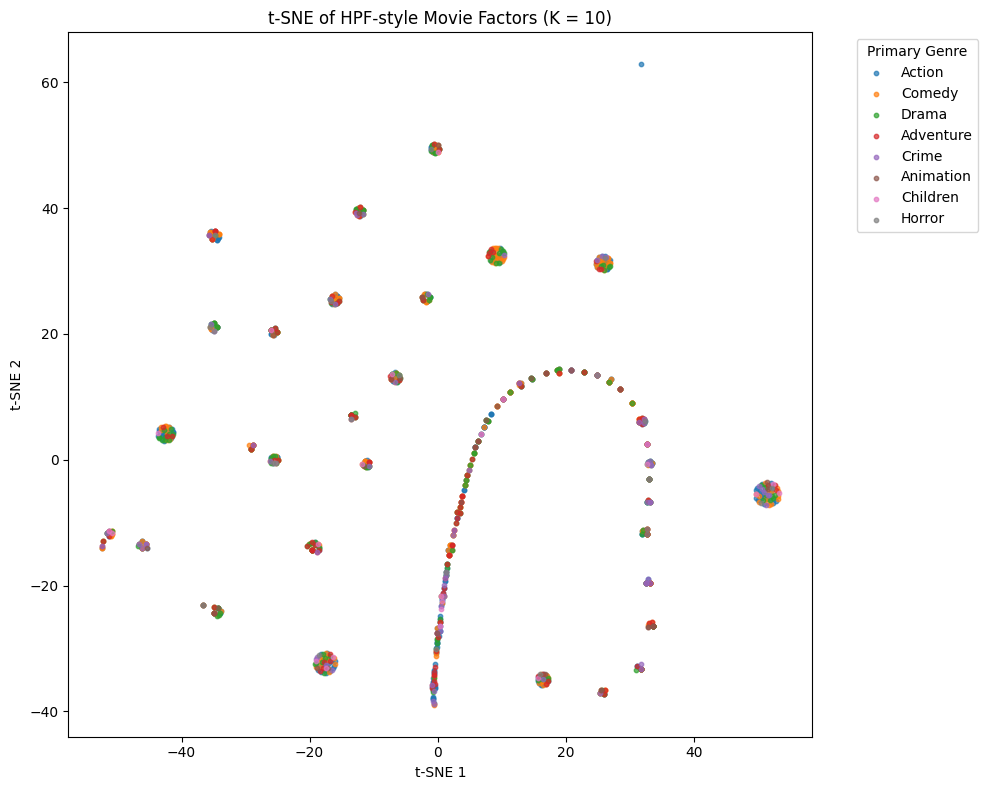

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Get HPF-style Beta for K = 10
beta_hpf_10 = [r for r in results_hpf if r["K"] == 10][0]["Beta"]  # shape: (M, 10)

# Use the same subset of movies as before (min 20 ratings)
min_ratings = 20
subset_hpf = movies_meta[movies_meta['num_ratings'] >= min_ratings].copy()

subset_indices = subset_hpf['movie_idx'].values
beta_hpf_subset = beta_hpf_10[subset_indices, :]

print("Subset size for HPF-style t-SNE:", beta_hpf_subset.shape)

# Same t-SNE settings as in Poisson PCA step
tsne_hpf = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    init="random",
    learning_rate="auto"
)

beta_hpf_2d = tsne_hpf.fit_transform(beta_hpf_subset)

subset_hpf["tsne_x"] = beta_hpf_2d[:, 0]
subset_hpf["tsne_y"] = beta_hpf_2d[:, 1]

plt.figure(figsize=(10, 8))

top_genres = subset_hpf['primary_genre'].value_counts().index[:8]

for g in top_genres:
    mask_g = subset_hpf['primary_genre'] == g
    plt.scatter(
        subset_hpf.loc[mask_g, "tsne_x"],
        subset_hpf.loc[mask_g, "tsne_y"],
        s=10,
        alpha=0.7,
        label=g
    )

plt.title("t-SNE of HPF-style Movie Factors (K = 10)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Primary Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [26]:
# Show top movies for the first few HPF-style factors
for k in range(3):
    print_top_movies_for_factor(beta_hpf_10, factor_idx=k, movies_meta=movies_meta, top_n=10)
    print()


Top 10 movies for factor 0:
  Forrest Gump (1994)                                          | Comedy          | score = 22.7407
  Shawshank Redemption, The (1994)                             | Crime           | score = 20.8318
  Pulp Fiction (1994)                                          | Comedy          | score = 20.4168
  Matrix, The (1999)                                           | Action          | score = 19.4209
  Silence of the Lambs, The (1991)                             | Crime           | score = 18.3419
  Star Wars: Episode IV - A New Hope (1977)                    | Action          | score = 17.1800
  Jurassic Park (1993)                                         | Action          | score = 16.8480
  Braveheart (1995)                                            | Action          | score = 16.5990
  Terminator 2: Judgment Day (1991)                            | Action          | score = 16.0181
  Schindler's List (1993)                                      | Drama           

### Step 4.4 – Visual Insights from HPF-style Movie Factors (K = 10)

Using the HPF-style Gamma–Poisson model with \(K = 10\), we visualized the **movie factor matrix**
\(\Beta \in \mathbb{R}_+^{M \times 10}\) in the same way as for Poisson PCA:

- t-SNE of movie factors for movies with ≥ 20 ratings, colored by **primary genre**.
- **Top movies per factor** for the first few latent dimensions.

#### (a) t-SNE of HPF-style movie factors

The HPF t-SNE plot shows:

- Movies are arranged along a **curved 1-D-like manifold** with several tight clumps rather than
  broad, separated genre regions.
- Within each clump, the colors (genres) are **heavily mixed**: Action, Comedy, Drama, etc. appear
  together instead of forming clean genre islands.
- Compared to the Poisson PCA t-SNE (which showed clearer genre-wise neighborhoods), the HPF
  visualization suggests that this model is organizing movies more by a **global latent axis**
  (roughly “overall strength / popularity”) than by fine-grained genre.

Overall, HPF-style factors for \(K = 10\) seem to emphasize **how strongly a movie is loaded on a
few dominant components**, rather than separating movies cleanly by content type.

#### (b) Top movies per HPF-style factor

The top-movies lists for the first HPF-style factors are dominated by the **same set of
high-profile 90s hits**:

- Factor 0 and Factor 1 both rank movies like  
  *Forrest Gump*, *The Shawshank Redemption*, *Pulp Fiction*, *The Matrix*,  
  *Silence of the Lambs*, *Star Wars: A New Hope*, *Jurassic Park*, *Braveheart*,  
  *Terminator 2*, *Schindler’s List* at the very top, with very similar scores.
- Factor 2 continues the pattern, again highlighting *Braveheart*, *Terminator 2*,
  *Schindler’s List*, etc.

This tells us that:

- Multiple latent dimensions are effectively capturing **the same “canonical blockbuster” signal**:
  critically acclaimed and very popular films are heavily loaded across several factors.
- In contrast to Poisson PCA (where Factor 0 aligned with family/animation and Factor 1 with
  sci-fi/superhero action), the HPF-style model at \(K = 10\) produces **less specialized,
  more redundant factors** focused on a shared set of globally popular titles.

#### Summary

- The HPF-style Gamma–Poisson model achieves strong **test log-likelihood** (best at \(K = 20\)),
  but at \(K = 10\) its latent factors are **less interpretable by genre** than those from Poisson
  PCA.
- Qualitatively, HPF-style factors emphasize a **single dominant popularity axis** and replicate
  similar “blockbuster” topics across multiple dimensions, whereas Poisson PCA yields more
  **diverse, genre-oriented components**.

This contrast between **good predictive performance** and **less distinct semantic structure** is
useful for the discussion section: HPF acts as a strong probabilistic baseline for counts, but
Poisson embeddings (and even Poisson PCA) may produce more interpretable latent spaces for movies.


## STEP 5 – Baseline Comparison and Abstract Draft

### 5.1 Combined Baseline Comparison (Poisson PCA vs HPF-style)

We compare the **Poisson PCA** baseline (Step 3) and the **HPF-style Gamma–Poisson factorization**
baseline (Step 4) on the same MovieLens implicit user–movie matrix and the same 80/20 per-user
train/test split. All numbers are **normalized Poisson test log-likelihood per entry**  
(higher = better; closer to 0 is better), with **standard error (SE)** across entries.

#### Test log-likelihood per entry ± SE

| Model                   | K   | Test ll/entry ± SE            |
|-------------------------|-----|-------------------------------|
| Poisson PCA             | 10  | -0.027445 ± 0.000173          |
| Poisson PCA             | 20  | -0.032663 ± 0.000220          |
| Poisson PCA             | 50  | -0.043058 ± 0.000290          |
| HPF-style Gamma–Poisson | 10  | -0.028375 ± 0.000070          |
| HPF-style Gamma–Poisson | 20  | **-0.023433 ± 0.000074**      |
| HPF-style Gamma–Poisson | 50  | -0.024706 ± 0.000074          |

#### Quantitative insights

- **Best overall baseline**:  
  - The HPF-style model with **\(K = 20\)** achieves the **highest test log-likelihood**  
    (closest to 0), making it the strongest baseline among those we tested.
- **Poisson PCA behavior**:
  - Poisson PCA performs best at **\(K = 10\)**, but performance **degrades** at
    \(K = 20\) and especially \(K = 50\), indicating **overfitting** as rank increases.
- **HPF-style behavior**:
  - The HPF-style model is more stable across K: it improves from \(K = 10\) to
    \(K = 20\), and only slightly worsens at \(K = 50\).
  - This suggests that the **Gamma priors and hierarchical structure act as
    regularizers**, allowing a moderately higher rank (\(K = 20\)) without severe
    overfitting.

#### Qualitative comparison (latent structure)

From the visual analyses:

- **Poisson PCA (K = 10)**:
  - t-SNE of movie factors shows **genre-aware clustering**: Action, Comedy, Drama,
    Animation/Children form recognizable neighborhoods.
  - Different components capture **distinct themes** (family/animation, sci-fi/action
    blockbusters, niche early-2000s comedies, etc.).
- **HPF-style (K = 10)**:
  - t-SNE arranges movies along a **curved 1-D-like manifold** with mixed colors; genre
    separation is weaker.
  - The first few factors are dominated by the **same canonical blockbusters**
    (*Forrest Gump*, *Shawshank Redemption*, *Pulp Fiction*, *The Matrix*, etc.),
    leading to **redundant factors** focused on global popularity rather than distinct
    genre topics.

**Takeaway:**  
HPF-style factorization delivers **better predictive log-likelihood** but produces **less
diverse, more popularity-driven factors**, whereas Poisson PCA offers more **genre-oriented and
interpretable latent dimensions**, despite slightly worse test likelihood.

---

### 5.2 Draft Abstract (using only Poisson PCA + HPF-style baselines)

> **Abstract (Draft)**
>
> We study low-rank models for implicit user–item feedback on the MovieLens
> dataset, focusing on how different Poisson factorization baselines capture
> movie structure. Starting from explicit ratings, we construct a binary
> user–movie matrix indicating whether each user has rated each title at least
> once, and perform an 80/20 per-user split into train and test interactions.
> As a first baseline, we fit a Poisson PCA model that factorizes the count
> matrix into non-negative user and movie factors and evaluate it via normalized
> Poisson log-likelihood on held-out entries. Poisson PCA achieves its best test
> performance at \(K = 10\) latent dimensions with a test log-likelihood of
> approximately \(-0.0274\) per entry, but degrades as the rank increases,
> indicating overfitting. We then implement an HPF-style Gamma–Poisson
> factorization model with Gamma priors on user and item factors. This model
> attains substantially better predictive performance, with a best test
> log-likelihood of about \(-0.0234\) per entry at \(K = 20\), while remaining
> more robust to over-parameterization. Qualitative analysis of the learned
> movie factors shows that Poisson PCA produces more distinct genre-oriented
> components (e.g., family animation, sci-fi/action blockbusters), whereas the
> HPF-style model organizes movies along a strong global popularity axis,
> emphasizing widely rated canonical films. These baselines provide both
> quantitative and qualitative reference points for our subsequent Poisson
> embedding models, which aim to combine strong predictive performance with more
> interpretable latent representations for movies.
